## Overview
I thought this would be a great chance to not only highlight some more functionality of [scikit-learn](https://scikit-learn.org/stable/index.html), but also a nice way to unite this with some of the basics of [Statistical Machine Learning](https://en.wikipedia.org/wiki/Statistical_learning_theory#:~:text=Statistical%20learning%20theory%20is%20a,predictive%20function%20based%20on%20data.)! The major concept here is to show you how you can integrate custom models into the **sklearn** infrastructure, particularly using [GridSearchCV](https://rainingstatsanddogs.github.io/intro-to-sklearn-best-practices.html). The example I'm going to show is very basic, and you can certainly do far more, though this is a good start. But before we get into the coding, let's start talking about the theory!

# Statistical Learning Theory
There are literal books on the subject so this is going to be a poor summary of a very rich and beautiful field. But at a high level, **Statistical Learning Theory** presumes that we have _feature vectors_ (aka "inputs"), $\vec{\pmb{X}}\in \mathbb{X} \subseteq \mathbb{R}^{k}$, and _labels_ (aka "outputs"), $\vec{\pmb{Y}}\in \mathbb{Y} \subseteq \mathbb{R}^{l}$, where $\mathbb{X}$ is the _Feature Space_ and $\mathbb{Y}$ is the _Label Space_. It is further assumed that there is some probability distribution over pairs of features and labels, aka $P(\vec{\pmb{X}}, \vec{\pmb{Y}})$. This is a powerful (and potentially subtle) statement which really deserves some consideration. The form form of this distribution can be complex or simple, but this is _the_ fundamental assumption of Statistical Learning Theory, in my opinion. Viewing the problem in this way lets us bring all the power of modern probability and statistics to bear to solve this problems, which means we can (or try) to utilize this joint distribution to construct marginals (e.g. $P(\vec{\pmb{Y}}$) and conditional distributions (e.g. $P(\vec{\pmb{Y}}|\vec{\pmb{X}})$) to help us understand and solve our problem. Of course, in practice we don't actually know this distribution and estimating it (or some aspect of it) is the major focus of Statistical Learning

Now here I want to focus our efforts a bit more. Statistical Learning Theory is a vast area which covers distinct principals like [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning), [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning) and [Reinforcement Learning](https://en.wikipedia.org/wiki/Reinforcement_learning). From now on (and in all prior posts) we'll be focussing on **Supervised Learning**, which effectively means we have training data where we know the desired outputs for a given input. Examples would be some characteristics of plants and what species they are, or being given details of a house and trying to predict its value. In the formalism of Learning Theory, the objective is learn a function $h,~h:\pmb{\vec{X}}\rightarrow\pmb{\vec{Y}}$ such that, given $(\pmb{\vec{x}},\pmb{\vec{y}}) \sim P(\pmb{\vec{X}},\pmb{\vec{Y}}),~h(\pmb{\vec{x}}) \approx \pmb{\vec{y}}$. This is where the major challenges come in and there is more set-up required here to properly develop some core concepts whichh are beyond the scope of this post. But with that, I want to focus on one last aspect.  

Some texts use $f$ or $g$ to denote the function we try to learn, but I like the texts that stick with $h$, as this (in my mind) stands for "hypothesis". We can then think of $h$ coming from a class of potential hypotheses, i.e. $h\in\mathcal{H}$! $\mathcal{H}$ can be basically whatever you want it to be! It's not just picking the best linear model or random forest ensemble; it  can be incredibly abstract. It can also contain very basic objects too, and this is what we will show how to fit in the sequence. To start with, let's simulate some fake data. In this case I'm going to go with a [regression](https://en.wikipedia.org/wiki/Regression_analysis#Regression_model), which means that our **label space** is a subset of the reals and infinite as opposed to when the label space is discrete (e.g. $\{-1, 0, 1\}$) which is a [classification](https://en.wikipedia.org/wiki/Statistical_classification) problem. 

In [193]:
# Import a few libraries
import numpy as np
import pandas as pd
# Setting a seed
np.random.seed(1234)
# Simulate some data; x is between 1 and 10; y is a function
x = np.linspace(1, 10, 30)
y = np.log(x) + (1 / x) ** 0.5 * np.sin(x)

And now  we can inspace this data.

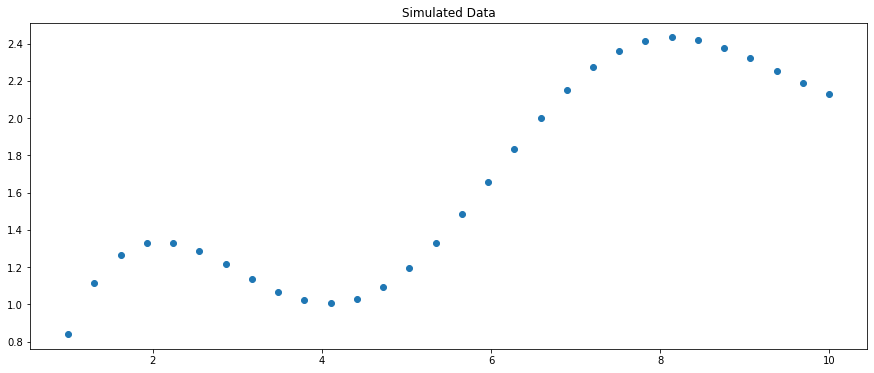

In [194]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15, 6))
plt.plot(x, y, marker = 'o', linestyle = 'none')
plt.title("Simulated Data");

As mentioned before, we want to find a function such that (in this case) $h(x)\approx y$. To be realistic, we should assume that we don't know the data-generating distribution, $P(x,y)$ and we want to estimate it. So let's explore a basic hypothesis: no matter what the input, $x$, we'll output a constant value: $c$. Put more formally, $$h_{constant}:\mathbb{R}\rightarrow c \in\mathbb{R}$$ Though this is trivial (and clearly not correct) we are going to use this as a springboard for creating our own custom estimator in **scikit-learn**! It turns out that making your own estimator can be pretty straight-forward. You simply need to create a class that has a `fit` and `predict` method. This follows the template from [this official documentation](https://scikit-learn.org/dev/developers/develop.html) which shows a classification method. The important aspects are that the new class we create is going to inherit from [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [RegressorMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html).

In [195]:
# Import needed libraries
from sklearn.base import BaseEstimator, RegressorMixin
# Import some tools to validate the custom estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class PickConstant(BaseEstimator, RegressorMixin):
    # I've initiated it with a constant of 1.5 based on eye-balling the data
    def __init__(self, constant_value = 1.5):
        self.constant_value = constant_value

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # To show the model was fit, we need to have appended 'X_' and 'y_' values
        self.X_ = X
        self.y_ = y
        # Return the "fitted" regressor
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        # Return our predicted (constant) value
        return self.constant_value * np.ones_like(X).reshape(-1, )

Let's check out the fit! We'll instatiate the class and see what we get:

In [196]:
# Instantiate the class with a constant value of 1.5
const_reg = PickConstant(1.5)
# Fit the model on the data (note we need to reshape 'x')
const_reg.fit(x.reshape(-1, 1), y)
# And make predictions!
const_pred = const_reg.predict(x.reshape(-1, 1))

In [197]:
# Check the results
const_pred

array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5])

The answers above look good! For each observation, we've predicted a constant value of 1.5! We can even visualize this now:

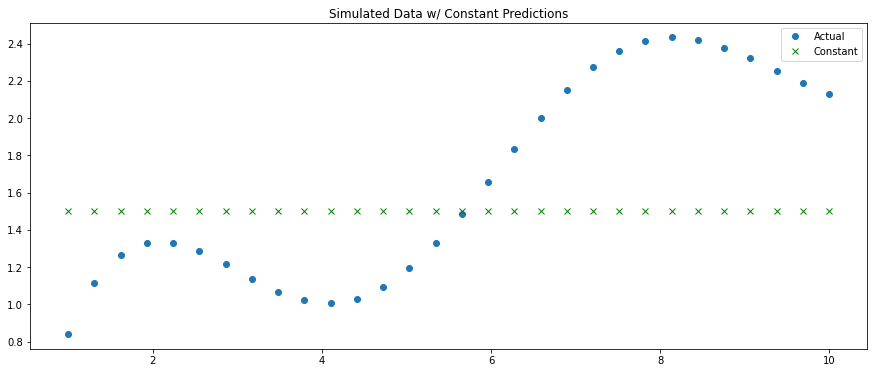

In [198]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.plot(x, y, marker = 'o', linestyle = 'none', label = 'Actual')
plt.plot(x, const_pred, marker = 'x', linestyle= 'none', color = 'green', label = 'Constant')
plt.title("Simulated Data w/ Constant Predictions")
plt.legend();

Pretty cool, huh! The hypothesis is obviously a bad fit, but at least we showed how to create a custom estimator in `sklearn`! Of course the real benefit of `sklearn` was its rich supporting features such as `Pipelines` and `GridSearch`. The good news is that we can use our custom estimator _inside_ of a `GridSearchCV` object! In this case, we want to find an optimal constant value rather than providing one. This means it is a hyperparamter we want to estimate within the CV operator. For the purpose of this post, we can explore a hyperparameter space between 0 & 3 to try and find the optimal value. As in [other posts](https://rainingstatsanddogs.github.io/intro-to-model-validation-1.html) on [the topic](https://rainingstatsanddogs.github.io/intro-to-model-validation-2.html), we simply need to name the value within the estimator in the `param_grid` & initiate a scoring function; in this case we'll use MSE. 

In [200]:
# Install GridSearchCV
from sklearn.model_selection import GridSearchCV

# Create a GridSearchCV object with our custom estimator.
regression_cv = GridSearchCV(PickConstant(), 
                             cv = 3, 
                             param_grid = {'constant_value': np.linspace(0, 3, 100)},
                             scoring = 'neg_mean_squared_error')

# Fit the object
regression_cv.fit(x.reshape(-1, 1), y);

Now let's see what the optimal value the `GridSearchCV` object returned:

In [199]:
regression_cv.best_params_

{'constant_value': 1.652076207620762}

Of course we know that the actual value that should minimize the square loss is the sample average. Let's see how close we came:

In [201]:
print(np.mean(y))

1.6520759103515146


That was pretty close but not perfect; we could improve the fit by providing a more granular `linspace` but for now this is adequate. But what if we wanted to try a more advanced hypothesis? Typically we never get access to the data-generating distribution, but we do get observable data, $\mathcal{D} = \{(x_{1}, y_{1}), (x_{2}, y_{2}), \ldots (x_{n}, y_{n})\}$. We can instead define a hypothesis as: $$h_{memorizer} := \begin{cases}y_{i}~\mathrm{if~}x=x_{i},x_{i}\in\mathcal{D} \\ c~else\end{cases}$$ In other words, if we've seen the existing data point before ($x = x_{i}$), we return the associated label ($y_{i}$). On the other hand, if the $x$ is new, we return some constant. This is slightly more advanced than what we did before, but still likely not the best approach possible. For instance, we typically have measurment error and multiple reads at the same input, so this would be a problem. Additionally, as the size of $\mathcal{D}$ increases, we'd have to maintain a massive database and look this up. But for now, let's make a new estimator:

In [208]:
class MemorizerOrConstant(BaseEstimator, RegressorMixin):

    def __init__(self, constant_value = 1.5):
        self.constant_value = constant_value

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.X_ = X
        self.y_ = y
        # Return the 'regressor'
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        # Mask if the input array exists in training data and grab first dimension
        # to index correctly into the y-array
        self.X_mask = np.argwhere(np.isin(X, self.X_))[:, 0]
        self.X__mask = np.argwhere(np.isin(self.X_, X))[:, 0]
        # Make output array for predicted y; assumes no matches => constant value
        pred_y = self.constant_value * np.ones(shape = np.shape(X)[0])
        pred_y[self.X_mask] = self.y_[self.X__mask]

        return pred_y

In [209]:
# Instantiate the class with a constant value of 1.5
mem_reg = MemorizerOrConstant(1.5)
# Fit the model on the data (note we need to reshape 'x')
mem_reg.fit(x.reshape(-1, 1), y)
# And make predictions!
mem_pred = mem_reg.predict(x.reshape(-1, 1))

In [210]:
# Show results
mem_pred

array([0.84147098, 1.11441658, 1.26738129, 1.33148827, 1.33040125,
       1.28498993, 1.21462762, 1.1371912 , 1.06853876, 1.02183117,
       1.00690314, 1.02981075, 1.09263117, 1.19355058, 1.32724201,
       1.48550459, 1.65811052, 1.83378763, 2.00125334, 2.15021243,
       2.2722352 , 2.36144422, 2.41495562, 2.43304332, 2.41901922,
       2.37884739, 2.32053319, 2.25334737, 2.18695803, 2.13055051])

This looks a little better! The values aren't constant, but this should be suprising since we are predicting our training data and all labels are known. To verify this, let's look at the plot:

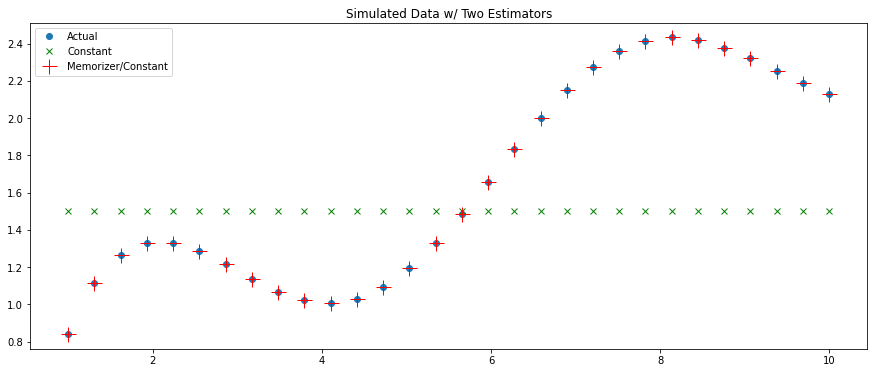

In [211]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.plot(x, y, marker = 'o', linestyle = 'none', label = 'Actual')
plt.plot(x, const_pred, marker = 'x', linestyle= 'none', color = 'green', label = 'Constant')
plt.plot(x, mem_pred, marker = '+', linestyle= 'none', markersize = 15, color = 'red', label = 'Memorizer/Constant')
plt.title("Simulated Data w/ Two Estimators")
plt.legend();

This plot confirms that we successfully memorized the training data. But if we tried a new $x$, we should see other values. To prove this, we can create many more training points that do not line up with most of our earlier training data:

In [216]:
# Make some new x values that will only align at the first and last value
new_x = np.linspace(1, 10, 301)

new_mem_reg = MemorizerOrConstant(1.5)
new_mem_reg.fit(x.reshape(-1, 1), y)
new_mem_pred = new_mem_reg.predict(new_x.reshape(-1, 1))

# View some of the data
new_mem_pred[:30]

array([0.84147098, 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ,
       1.5       , 1.5       , 1.5       , 1.5       , 1.5       ])

This looks remarkably different than before! That's because most of the values in `new_x` aren't in the training data; just the first and last points, which we can see by viewing the plot:

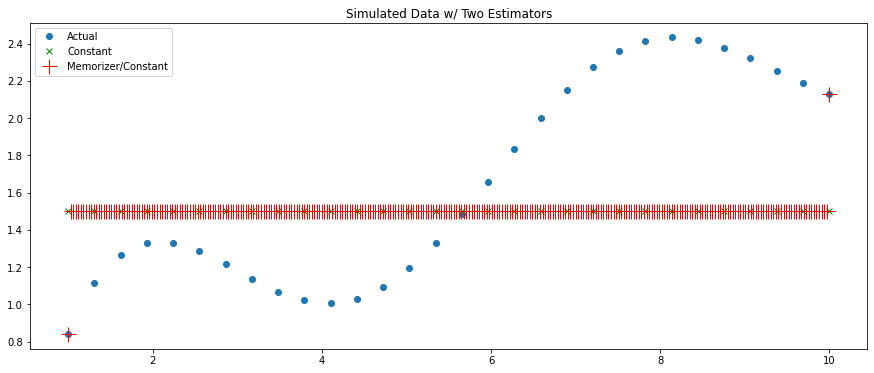

In [217]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.plot(x, y, marker = 'o', linestyle = 'none', label = 'Actual')
plt.plot(x, const_pred, marker = 'x', linestyle= 'none', color = 'green', label = 'Constant')
plt.plot(new_x, new_mem_pred, marker = '+', linestyle= 'none', markersize = 15, color = 'red', label = 'Memorizer/Constant')
plt.title("Simulated Data w/ Two Estimators")
plt.legend();

We can also put our `Memorizer` into a `GridSearchCV` object and find an optimal $c$, or come up with some other custom estimators. But at this point, that's enough for this post. 

## Summary
In this post, we covered some basics about Statistical Learning Theory, created two rudimentary hypotheses that we implemented into `sklearn` and even put one into a `GridSearchCV` object and tuned the hyperparameter. Perhaps future posts will cover integrating other objects into `sklearn` or more theory about Statistical Machine Learning. If you have an opinion, please let me know in the comments!